# Lab 2. LLM Quantization Lab

This lab source is partly based on

- EfficientML.ai Lab https://hanlab.mit.edu/courses/2023-fall-65940
- KoAlpaca+GPTQ git https://github.com/qwopqwop200/GPTQ-for-KoAlpaca



Updated by Geonho Lee, Sungwan Ryu 2024.8.25

Created by Minsoo Kim 2023.11.03

## Part1. LLM Quantization with GPTQ, AWQ, and NF4

### Package pip install & import (~3m)

In [1]:
print('Installing packages...')
!pip install -U git+https://github.com/huggingface/transformers.git
!pip install -U git+https://github.com/huggingface/accelerate.git
!pip install datasets
!pip install torch tqdm
!pip install autoawq
!pip install transformers
!pip install -U auto-gptq optimum
!pip install --upgrade torchvision

Installing packages...
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-5hlgrgyb
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-5hlgrgyb
  Resolved https://github.com/huggingface/transformers.git to commit f42084e6411c39b74309af4a7d6ed640c01a4c9e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.48.0.dev0-py3-none-any.whl size=10283310 sha256=93c6314f498b8a05c2e368b2a9e1526e6e928657e164d506c32a6377e224872b
  Stored in directory: /tmp/pip-ephem-wheel-cache-z4pwm053/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
  Cl

#### 런타임 - 세션 다시 시작

In [1]:
# Import Libraries
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, BitsAndBytesConfig
import datasets
from datasets import load_dataset
from functools import partial
import gc
import copy

In [2]:
# Function to evaluate perplexity
def evaluate(model, tokenizer):
    testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')

    testenc = testenc.input_ids.to(model.device)
    nsamples = 40
    model = model.eval()

    nlls = []
    for i in tqdm.tqdm(range(nsamples), desc="evaluating..."):
        batch = testenc[:, (i * 2048):((i + 1) * 2048)].to(model.device)
        with torch.no_grad():
            lm_logits = model(batch).logits
        shift_logits = lm_logits[:, :-1, :].contiguous().float()
        shift_labels = testenc[:, (i * 2048):((i + 1) * 2048)][:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * 2048
        nlls.append(neg_log_likelihood)

    return torch.exp(torch.stack(nlls).sum() / (nsamples * 2048))

In [3]:
# Function to prune weights
def prune_weights(model, pruning_percentage):
    total_params = 0
    pruned_params = 0

    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name and param.requires_grad:
                weight_data = param.data.view(-1)
                k = int(pruning_percentage / 100 * weight_data.numel())
                if k == 0:
                    continue
                threshold = torch.topk(weight_data.abs(), k, largest=False).values.max()
                mask = torch.abs(param.data) >= threshold
                pruned_params += param.numel() - mask.sum().item()
                param.data *= mask
                total_params += param.numel()

    pruning_ratio = pruned_params / total_params * 100
    print(f"Total parameters: {total_params}")
    print(f"Pruned parameters: {pruned_params}")
    print(f"Actual pruning ratio: {pruning_ratio:.2f}%")

    return model

In [4]:
# Main script
model_path = "facebook/opt-350m"

# Load baseline model
print("Loading baseline model...")
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
baseline_model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
for param in baseline_model.parameters():
    param.requires_grad = False
baseline_model.config.use_cache = False
baseline_model.eval()
gc.collect()
torch.cuda.empty_cache()

Loading baseline model...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [5]:
# Evaluate baseline model
print("Evaluating baseline model...")
baseline_ppl = evaluate(baseline_model, tokenizer)
print(f"Baseline model perplexity: {baseline_ppl:.2f}")

# Apply GPTQ quantization
print("Applying GPTQ quantization...")
quantization_config = GPTQConfig(bits=4, dataset="c4", tokenizer=tokenizer)
gptq_model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto", quantization_config=quantization_config)
for param in gptq_model.parameters():
    param.requires_grad = False
gptq_model.config.use_cache = False
gptq_model.eval()

# Evaluate GPTQ model
print("Evaluating GPTQ model...")
gptq_ppl = evaluate(gptq_model, tokenizer)
print(f"GPTQ model perplexity: {gptq_ppl:.2f}")

Evaluating baseline model...


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

evaluating...: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]


Baseline model perplexity: 21.91
Applying GPTQ quantization...


/usr/local/lib/python3.10/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:411: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, qweight, scales, qzeros, g_idx, bits, maxq):
/usr/local/lib/python3.10/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:419: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/usr/local/lib/python3.10/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)


README.md:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

c4-train.00000-of-01024.json.gz:   0%|          | 0.00/319M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

model.safetensors:   0%|          | 0.00/662M [00:00<?, ?B/s]

Quantizing model.decoder.layers blocks :   0%|          | 0/24 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:5057: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Evaluating GPTQ model...


evaluating...: 100%|██████████| 40/40 [00:02<00:00, 15.40it/s]


GPTQ model perplexity: 23.27


In [6]:
# Save and reload the GPTQ model to ensure the state is consistent
gptq_model.save_pretrained("opt-350m-gptq")
tokenizer.save_pretrained("opt-350m-gptq")

('opt-350m-gptq/tokenizer_config.json',
 'opt-350m-gptq/special_tokens_map.json',
 'opt-350m-gptq/vocab.json',
 'opt-350m-gptq/merges.txt',
 'opt-350m-gptq/added_tokens.json')

In [7]:
# Apply pruning to GPTQ model

# Load the saved GPTQ model
gptq_model = AutoModelForCausalLM.from_pretrained("opt-350m-gptq", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("opt-350m-gptq", use_fast=False)

print("Applying pruning to GPTQ model...")
pruning_percentage = 35  # Percentage of weights to prune
pruned_gptq_model = prune_weights(gptq_model, pruning_percentage)
gc.collect()
torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:5057: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


Applying pruning to GPTQ model...
Total parameters: 28936192
Pruned parameters: 10109807
Actual pruning ratio: 34.94%


In [8]:
# Evaluate pruned GPTQ model
print("Evaluating pruned GPTQ model...")
pruned_gptq_ppl = evaluate(pruned_gptq_model, tokenizer)
print(f"Pruned GPTQ model perplexity: {pruned_gptq_ppl:.2f}")

print("Summary of results:")
print(f"Baseline model perplexity: {baseline_ppl:.2f}")
print(f"GPTQ model perplexity: {gptq_ppl:.2f}")
print(f"Pruned GPTQ model perplexity: {pruned_gptq_ppl:.2f}")

Evaluating pruned GPTQ model...


evaluating...: 100%|██████████| 40/40 [00:02<00:00, 15.26it/s]

Pruned GPTQ model perplexity: 40.58
Summary of results:
Baseline model perplexity: 21.91
GPTQ model perplexity: 23.27
Pruned GPTQ model perplexity: 40.58


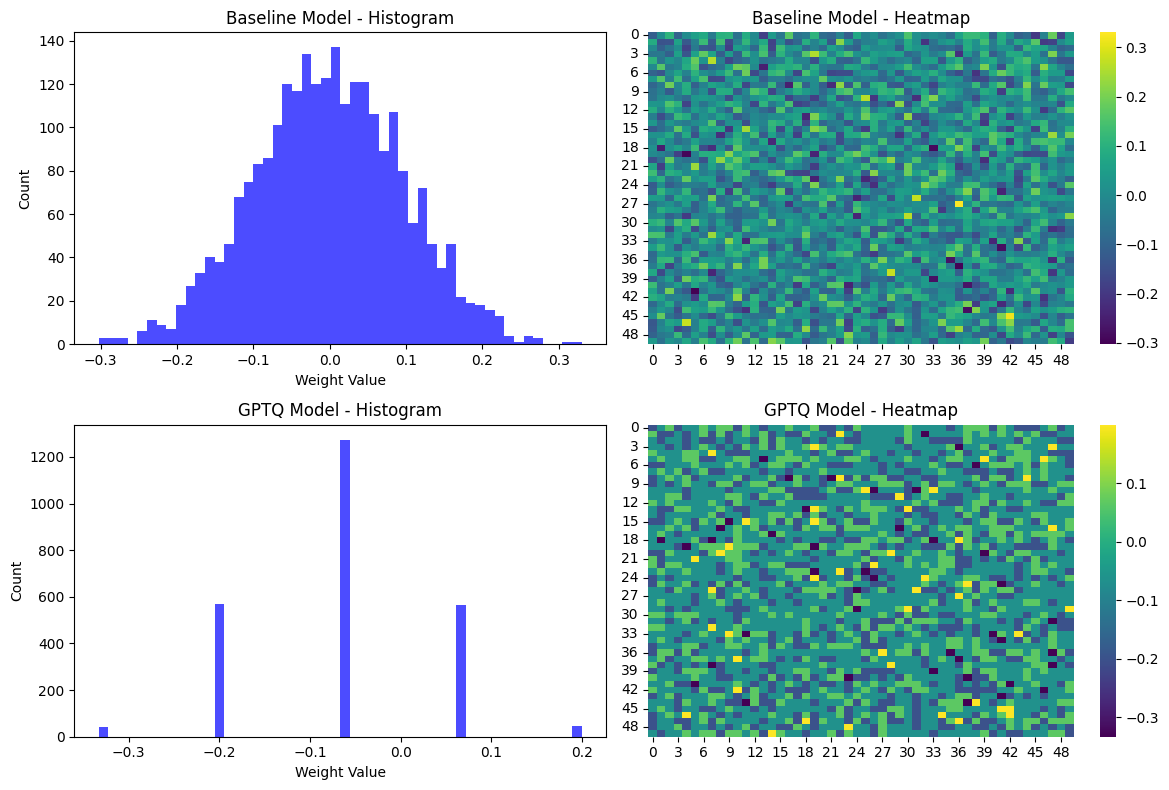

In [12]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Helper function to plot histograms and heatmaps of weights
def plot_gptq_distributions(baseline_weights, gptq_weights):
    """
    Plots histograms and heatmaps for weights of Baseline and GPTQ models.

    Parameters:
    - baseline_weights (torch.Tensor): Weights of the baseline model.
    - gptq_weights (torch.Tensor): Weights of the GPTQ model.
    """
    # Flatten weights for histograms
    baseline_flat = baseline_weights.flatten()
    gptq_flat = gptq_weights.flatten()

    plt.figure(figsize=(12, 8))

    # Baseline - Histogram
    plt.subplot(2, 2, 1)
    plt.hist(baseline_flat, bins=50, color='blue', alpha=0.7)
    plt.title("Baseline Model - Histogram")
    plt.xlabel("Weight Value")
    plt.ylabel("Count")

    # Baseline - Heatmap
    plt.subplot(2, 2, 2)
    sns.heatmap(baseline_weights, cmap='viridis', cbar=True)
    plt.title("Baseline Model - Heatmap")

    # GPTQ - Histogram
    plt.subplot(2, 2, 3)
    plt.hist(gptq_flat, bins=50, color='blue', alpha=0.7)
    plt.title("GPTQ Model - Histogram")
    plt.xlabel("Weight Value")
    plt.ylabel("Count")

    # GPTQ - Heatmap
    plt.subplot(2, 2, 4)
    sns.heatmap(gptq_weights, cmap='viridis', cbar=True)
    plt.title("GPTQ Model - Heatmap")

    plt.tight_layout()
    plt.show()

# Ensure memory is clear
gc.collect()

# Simulated models for demonstration
baseline_model = torch.nn.Linear(50, 50)  # Model size is 50x50
gptq_model = torch.nn.Linear(50, 50)

with torch.no_grad():
    # Baseline weights
    baseline_model.weight = torch.nn.Parameter(torch.randn_like(baseline_model.weight) * 0.1)

    # GPTQ weights (4-bit quantization)
    quantization_levels = torch.linspace(-1.0, 1.0, steps=16)  # 4-bit quantization
    quantized_weights = torch.bucketize(baseline_model.weight, quantization_levels) - 1
    quantized_weights = quantization_levels[quantized_weights]
    gptq_model.weight = torch.nn.Parameter(quantized_weights)

# Plot histograms and heatmaps for Baseline and GPTQ weight sets
plot_gptq_distributions(
    baseline_model.weight.detach().cpu().numpy(),
    gptq_model.weight.detach().cpu().numpy()
)
